# Omnigot One-Shot with Virtual Branching

In [5]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [6]:
import vbranch as vb

In [7]:
model_id = 1
architecture = 'simple'

## Load Data

In [8]:
train_generator = vb.datasets.omniglot.load_generator('train')
test_generator = vb.datasets.omniglot.load_generator('test')

In [9]:
batch = test_generator.next(4, 4, 4, flatten=False)

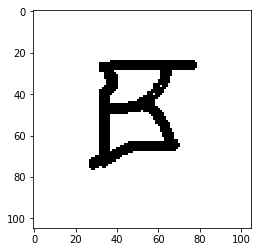

In [10]:
plt.imshow(batch[2, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [11]:
EPOCHS = 90
STEPS_PER_EPOCH = 100
T_0 = 30

NUM_BRANCHES = 3
SHARED_FRAC = 0.5
model_path = os.path.join('models', 'vb-omniglot-{}-B{:d}-S{:.2f}_{:d}'.format(architecture,
    NUM_BRANCHES, SHARED_FRAC, model_id))

A, P, K = 4, 8, 4 # triplet batch specs
output_dim = 128
input_dim = [None, 105, 105, 1]

In [8]:
if not os.path.isdir('./models'):
    os.system('mkdir models')

In [9]:
def batch_gen(A, P, K):
    def func():
        while True:
            batch = train_generator.next(A, P, K)
            batch = batch.astype('float32')
            yield batch
    return func

In [10]:
tf.reset_default_graph()

# Placeholder for feeding test images
x = tf.placeholder('float32', input_dim, name='x')
batch_size = tf.placeholder('int64', name='batch_size')

train_datasets = []
test_datasets = []
inputs = [None] * NUM_BRANCHES
train_init_ops = []
test_init_ops = []

for i in range(NUM_BRANCHES):
    train_datasets.append( tf.data.Dataset.from_generator(batch_gen(A, P, K), 
                                                          'float32', 
                                                          output_shapes=input_dim))

    test_datasets.append(tf.data.Dataset.from_tensor_slices(x).batch(batch_size))
    
    iterator = tf.data.Iterator.from_structure('float32', input_dim)
    inputs[i] = iterator.get_next(name='input_'+str(i+1))    

    train_init_ops.append(iterator.make_initializer(train_datasets[i]))
    test_init_ops.append(iterator.make_initializer(test_datasets[i], 
                                                name='test_init_op_'+str(i+1)))

In [11]:
if architecture == 'simple':        
    filters = [32, 64, 128, 256]
    layers_spec = [([f]*NUM_BRANCHES, int(f*SHARED_FRAC)) for f in filters]

    model = vb.vbranch_simple_cnn(inputs, (output_dim, 0), *layers_spec,
        branches=NUM_BRANCHES, name='model_' + str(model_id))

elif architecture == 'res':
    model = vb.res_cnn(inputs, output_dim, 32, 64, 128, 256)

In [12]:
model.summary()

i   Layer name         Output shape                          Num param  Inbound            
-------------------------------------------------------------------------------------------
    Input              [None,105,105,1]                                                    
-------------------------------------------------------------------------------------------
    Input              [None,105,105,1]                                                    
-------------------------------------------------------------------------------------------
    Input              [None,105,105,1]                                                    
-------------------------------------------------------------------------------------------
0   conv2d_1_1         [None,103,103,16] [None,103,103,16]   640        input              
                       [None,103,103,16] [None,103,103,16]                                 
                       [None,103,103,16] [None,103,103,16]                      

In [13]:
def lr_exp_decay_scheduler(init_lr, t0, t1, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / (t1 - t0))
        return lr
    return func

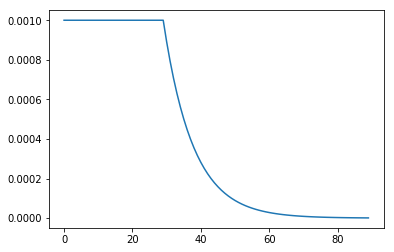

In [14]:
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [15]:
lr = tf.placeholder('float32', name='lr')
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# Compile model
model.compile(optimizer, 'triplet_omniglot', A=A, P=P, K=K)

In [23]:
model.output

[<tf.Tensor 'model_1/model_1/output_vb1:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model_1/model_1/output_vb2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model_1/model_1/output_vb3:0' shape=(?, 128) dtype=float32>]

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_ops)

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        learning_rate = lr_scheduler(e + 1)
        for i in range(STEPS_PER_EPOCH):
            _, loss_values = sess.run([model.train_ops, model.losses], feed_dict={lr:learning_rate})
            progbar.update(i + 1, values=[('loss_'+str(b+1), loss_values[b]) for b in range(len(loss_values))] \
                           + [('lr', learning_rate),])
    
    saver = tf.train.Saver()
    path = os.path.join(model_path, 'ckpt')
    saver.save(sess, path)

Epoch 1/90
100/100 [==============================] - 180s 2s/step - loss_1: 237.6685 - loss_2: 235.0316 - loss_3: 253.3819 - lr: 0.0010
Epoch 2/90
100/100 [==============================] - 92s 916ms/step - loss_1: 67.6989 - loss_2: 62.9552 - loss_3: 71.0828 - lr: 0.0010
Epoch 3/90
100/100 [==============================] - 91s 914ms/step - loss_1: 49.5306 - loss_2: 46.0332 - loss_3: 51.6713 - lr: 0.0010
Epoch 4/90
100/100 [==============================] - 91s 910ms/step - loss_1: 39.0302 - loss_2: 37.5737 - loss_3: 41.0405 - lr: 0.0010
Epoch 5/90
100/100 [==============================] - 91s 910ms/step - loss_1: 35.9236 - loss_2: 36.5205 - loss_3: 31.2357 - lr: 0.0010
Epoch 6/90
100/100 [==============================] - 91s 912ms/step - loss_1: 29.2729 - loss_2: 28.7048 - loss_3: 28.8384 - lr: 0.0010
Epoch 7/90
100/100 [==============================] - 91s 907ms/step - loss_1: 30.6997 - loss_2: 26.1090 - loss_3: 26.2196 - lr: 0.0010
Epoch 8/90
100/100 [===========================

## Model Ensemble

In [1]:
def restore_sess(sess, model_path):
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

In [2]:
def get_run(n_run):
    all_runs = './omniglot/python/one-shot-classification/all_runs'
    
    if not os.path.isdir(all_runs):
        with zipfile.ZipFile(all_runs + '.zip','r') as zip_ref:
            zip_ref.extractall(all_runs)
    
    run_path = os.path.join(all_runs,'run%02d'%n_run,'class_labels.txt')
    with open(run_path) as f:
        content = f.read().splitlines()

    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]

    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    
    def f_load(f):
        path = os.path.join(all_runs, f)
        return cv2.imread(path)[..., 0]

    train_imgs = np.stack([f_load(f) for f in train_files]).\
                        astype('float32')[..., np.newaxis]
    test_imgs  = np.stack([f_load(f) for f in test_files]).\
                        astype('float32')[..., np.newaxis]

    return train_files, test_files, train_imgs, test_imgs, answers_files

In [3]:
def compute_one_shot_acc(test_pred, train_pred, train_files, answers_files):
    n_test = len(test_pred)
    n_train = len(train_pred)
    
    distM = np.zeros((n_test, n_train))
    for i in range(n_test):
        for c in range(n_train):
            distM[i,c] = distance.euclidean(test_pred[i],train_pred[c])
            
    YHAT = np.argmin(distM, axis=1)
    
    # compute the error rate
    correct = 0.0
    for i in range(n_test):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
        
    return correct / n_test

In [12]:
test_init_ops = ['test_init_op_'+str(i+1) for i in range(NUM_BRANCHES)]
model_outputs = ['model_1/model_1/output_vb{}:0'.format(i+1) for i in range(NUM_BRANCHES)]

In [13]:
total_runs = 20
train_pred_runs = []
test_pred_runs = []

run_data = [get_run(r+1) for r in range(total_runs)]

with tf.Session() as sess:
    restore_sess(sess, model_path)

    for r in range(total_runs):
        train_files,test_files,train_imgs,test_imgs,answers_files = run_data[r]

        feed_dict = {'x:0':train_imgs, 'batch_size:0':len(train_imgs)}
        sess.run(test_init_ops, feed_dict=feed_dict)
        train_pred_runs.append(sess.run(model_outputs))

        feed_dict = {'x:0':test_imgs, 'batch_size:0':len(test_imgs)}
        sess.run(test_init_ops, feed_dict=feed_dict)
        test_pred_runs.append(sess.run(model_outputs))

INFO:tensorflow:Restoring parameters from models/vb-omniglot-simple-B3-S0.50_1/ckpt


### Average Embedding

In [21]:
mean_acc_runs = []
for r in range(total_runs):
    test_embed = np.mean(test_pred_runs[r], axis=0)
    train_embed = np.mean(train_pred_runs[r], axis=0)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    mean_acc_runs.append(acc)

In [22]:
print(mean_acc_runs)
print(np.mean(mean_acc_runs))

[0.9, 0.85, 0.85, 0.95, 0.8, 0.95, 0.85, 0.85, 0.7, 0.85, 1.0, 0.75, 0.75, 0.65, 1.0, 1.0, 0.8, 0.9, 0.6, 0.85]
0.8425


### Concatenate Embedding

In [25]:
concat_acc_runs = []
for r in range(total_runs):
    test_embed = np.concatenate(test_pred_runs[r], axis=-1)
    train_embed = np.concatenate(train_pred_runs[r], axis=-1)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
        
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    concat_acc_runs.append(acc)

In [26]:
print(concat_acc_runs)
print(np.mean(concat_acc_runs))

[0.8, 0.8, 0.85, 0.9, 0.85, 0.95, 0.9, 0.7, 0.75, 0.85, 1.0, 0.8, 0.6, 0.75, 1.0, 1.0, 0.85, 0.95, 0.65, 0.9]
0.8424999999999999
